# Statistical Analysis

In [32]:
from scipy import stats

import numpy as np
import pandas as pd
import seaborn as sns
import cufflinks as cf
import plotly.express as px
from ipywidgets import interact

In [33]:
pd.options.plotting.backend = 'plotly'

In [34]:
df = pd.read_csv('project-public-clean.csv')

In [35]:
df.set_index(df['EEID'], inplace=True)
df.drop(columns='EEID', inplace=True)

In [36]:
df['Attrition'] = pd.get_dummies(df['Termination Type'], drop_first=True)

In [37]:
stats.shapiro(df['Attrition'])
# p-value muy pequeño - rechazamos h0 y conlcuimos que no tiene distribución normal
# tiene setnido para variables categoricas?

ShapiroResult(statistic=0.5796045064926147, pvalue=8.905712801610138e-36)

In [38]:
# tiene sentido hacerlo con todo el histórico o mejor por años?
# df['Involuntary'], df['Voluntary'] = pd.get_dummies(df['Termination Type'])

## Does division afect attrition?

In [39]:
df['Division'] = df['Division'].apply(lambda x: 'People & Home' if 'People' in x or 'Home' in x else x)

In [40]:
df['Division'] = df['Division'].apply(lambda x: 'Finance & Legal' if 'Finance' in x else x)

In [41]:
df['Division'] = df['Division'].apply(lambda x: 'Leadership' if 'Founders' in x else x)

In [42]:
df.groupby('Division').sum()['Attrition'] / df.groupby('Division').count()['Attrition']

Division
Business Development    0.294118
Customer Success        0.233766
Data & Analytics        0.228070
Design                  0.272727
Engineering             0.382775
Finance & Legal         0.272727
Leadership              0.333333
Marketing               0.327586
People & Home           0.272727
Product                 0.400000
R&D                     0.000000
Security                0.000000
Strategy                0.000000
Unknown                 0.333333
Name: Attrition, dtype: float64

In [43]:
df_chi = pd.DataFrame(df.groupby('Division').sum()['Attrition'] / df.groupby('Division').count()['Attrition'])

In [44]:
df_chi['Not_Attrition'] = 1 - df_chi['Attrition']

In [45]:
df_chi

,Attrition,Not_Attrition
Division,,
Business Development,0.294118,0.705882
Customer Success,0.233766,0.766234
Data & Analytics,0.228070,0.771930
Design,0.272727,0.727273
Engineering,0.382775,0.617225
Finance & Legal,0.272727,0.727273
Leadership,0.333333,0.666667
Marketing,0.327586,0.672414
People & Home,0.272727,0.727273


In [46]:
df_chi2 = pd.DataFrame(df.groupby('Division').sum()['Attrition'])

In [47]:
df_chi2['Not_Attrition'] = df.groupby('Division').count()['Attrition'] - df_chi2['Attrition']

In [48]:
df_chi2

,Attrition,Not_Attrition
Division,,
Business Development,5,12
Customer Success,18,59
Data & Analytics,13,44
Design,12,32
Engineering,80,129
Finance & Legal,6,16
Leadership,1,2
Marketing,19,39
People & Home,15,40


In [49]:
stats.chi2_contingency(df_chi2)
# p-value muy cerca de 0.05

(21.460859038044806,
 0.06429935888588138,
 13,
 array([[  5.2092257 ,  11.7907743 ],
        [ 23.59472817,  53.40527183],
        [ 17.46622735,  39.53377265],
        [ 13.48270181,  30.51729819],
        [ 64.04283361, 144.95716639],
        [  6.74135091,  15.25864909],
        [  0.91927512,   2.08072488],
        [ 17.77265239,  40.22734761],
        [ 16.85337727,  38.14662273],
        [ 12.25700165,  27.74299835],
        [  0.91927512,   2.08072488],
        [  2.45140033,   5.54859967],
        [  3.37067545,   7.62932455],
        [  0.91927512,   2.08072488]]))

In [50]:
df_chi2.iplot('bar')

## Does salary affect attrition?

In [51]:
stats.shapiro(df['Pay rate'])
# distribución de salarios no normal
# tenemos que hacer t-test o wilcoxon? Para hacer paramétrico, necesitamos que Attrition tenga distribución normal, o Pay rate?

ShapiroResult(statistic=0.685462236404419, pvalue=4.617287149542632e-32)

In [52]:
stats.ttest_ind(df['Attrition'], df['Pay rate'])
# p-value muy bajo, rechazamos H0 y aceptamos que el salario tiene influencia en la Attrition

Ttest_indResult(statistic=-37.32265274374822, pvalue=1.3206941671660246e-203)

In [53]:
stats.wilcoxon(df['Attrition'], df['Pay rate'])
# p-value muy bajo, rechazamos H0 y aceptamos que el salario tiene influencia en la Attrition

WilcoxonResult(statistic=0.0, pvalue=4.259878942892629e-101)

In [54]:
df['Pay rate'].iplot('hist')

In [55]:
df[['Division', 'Pay rate']].pivot(columns='Division', values='Pay rate').iplot(kind='box')

In [56]:
df['Pay rate - Currency code'].value_counts()

EUR    537
USD     62
GBP      8
Name: Pay rate - Currency code, dtype: int64

In [57]:
# convertir todos los salarios a euros: 1USD = 0.82€, 1GBP = 1,16€

In [58]:
# df['Pay rate'].apply(lambda x: x*0.82 if x['Pay rate - Currency code'] == 'USD' else x)

In [59]:
# for idx, row in df.iteritems():
#     print(idx, row)
#    if row[idx,'Pay rate - Currency code'] == 'USD':
#        row[idx,'Pay rate'] = row[idx,'Pay rate'] * 0.82
#    

In [60]:
df['Pay rate EUR'] = np.where(df['Pay rate - Currency code'] == 'USD', df['Pay rate'] * 0.82, df['Pay rate'])
# también funcionaría con lo siguiente, pero me queda mas claro usando np.where: df.apply(lambda x: (x['Pay rate'] * 0.82) if x['Pay rate - Currency code'] == 'USD' else x['Pay rate'], axis=1)

In [61]:
df['Pay rate EUR'] = np.where(df['Pay rate - Currency code'] == 'GBP', df['Pay rate'] * 1.16, df['Pay rate EUR'])

In [62]:
# Para comprobar que está bien:
df[['Pay rate', 'Pay rate - Currency code', 'Pay rate EUR']][df['Pay rate - Currency code'] == 'GBP']

,Pay rate,Pay rate - Currency code,Pay rate EUR
EEID,,,
700,41600.0,GBP,48256.0
697,44000.0,GBP,51040.0
779,44000.0,GBP,51040.0
698,56000.0,GBP,64960.0
774,68000.0,GBP,78880.0
757,68000.0,GBP,78880.0
731,96000.0,GBP,111360.0
161,99200.0,GBP,115072.0


In [67]:
# Location
df['Location'] = df.apply(lambda x: 'North America' if x['Pay rate - Currency code'] == 'USD' else 'Europe', axis=1)

In [69]:
# Reordenamos las columnas para que quede más claro:
df = df[['Status', 'Age', 'Gender', 'Education Level', 'Hire Date', 
       'Termination Date', 'Termination Type', 'Termination Reason', 'Attrition',
       'Job Information: Date', 'Location', 'Division', 'Department', 'Supervisor EID',
       'Pay rate', 'Pay rate - Currency code', 'Pay rate EUR', 'Compensation Change Reason',
       'Stock Options', 'Level', 'Is Supervisor', 'Length of service',
       'Length of service: Years', 'Length of service: Months']]

In [70]:
df.head()

,Status,Age,Gender,Education Level,Hire Date,Termination Date,Termination Type,Termination Reason,Attrition,Job Information: Date,...,Pay rate,Pay rate - Currency code,Pay rate EUR,Compensation Change Reason,Stock Options,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months
EEID,,,,,,,,,,,,,,,,,,,,,
343,Inactive,28,Female,Undergraduate degree (Grado),2019-08-19,2019-09-30,Involuntary,End of contract,0,2019-08-19,...,6047.0,EUR,6047.0,Reduce/Increase Working hours,N,Unknown,No,"1 month, 11 days",0,1
468,Inactive,29,Male,Unknown,2016-07-05,2017-03-30,Involuntary,End of contract,0,2016-07-05,...,6144.0,EUR,6144.0,Unknown,N,Unknown,No,"8 months, 25 days",0,8
458,Inactive,27,Male,Unknown,2016-09-05,2017-01-26,Involuntary,End of contract,0,2016-09-05,...,6144.0,EUR,6144.0,Unknown,N,Unknown,No,"4 months, 21 days",0,4
379,Inactive,25,Male,Undergraduate degree (Grado),2017-10-23,2018-08-28,Involuntary,End of contract,0,2017-10-23,...,6144.0,EUR,6144.0,New hire,N,Unknown,No,"10 months, 5 days",0,10
492,Inactive,58,Female,Unknown,2017-09-13,2017-09-29,Involuntary,End of contract,0,2017-09-13,...,7200.0,EUR,7200.0,Unknown,N,Unknown,No,16 days,0,0


In [56]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding

In [57]:
df = pd.read_csv('project-public-clean.csv')

In [58]:
df.set_index(df['EEID'], inplace=True)
df.drop(columns='EEID', inplace=True)

In [59]:
df.head()

,Status,Age,Gender,Education Level,Hire Date,Termination Date,Termination Type,Termination Reason,Job Information: Date,Division,...,Supervisor EID,Pay rate,Pay rate - Currency code,Compensation Change Reason,Stock Options,Level,Is Supervisor,Length of service,Length of service: Years,Length of service: Months
EEID,,,,,,,,,,,,,,,,,,,,,
343,Inactive,28,Female,Undergraduate degree (Grado),2019-08-19,2019-09-30,Involuntary,End of contract,2019-08-19,People,...,1,6047.0,EUR,Reduce/Increase Working hours,N,Unknown,No,"1 month, 11 days",0,1
468,Inactive,29,Male,Unknown,2016-07-05,2017-03-30,Involuntary,End of contract,2016-07-05,Engineering,...,234,6144.0,EUR,Unknown,N,Unknown,No,"8 months, 25 days",0,8
458,Inactive,27,Male,Unknown,2016-09-05,2017-01-26,Involuntary,End of contract,2016-09-05,Engineering,...,0,6144.0,EUR,Unknown,N,Unknown,No,"4 months, 21 days",0,4
379,Inactive,25,Male,Undergraduate degree (Grado),2017-10-23,2018-08-28,Involuntary,End of contract,2017-10-23,Engineering,...,0,6144.0,EUR,New hire,N,Unknown,No,"10 months, 5 days",0,10
492,Inactive,58,Female,Unknown,2017-09-13,2017-09-29,Involuntary,End of contract,2017-09-13,People,...,0,7200.0,EUR,Unknown,N,Unknown,No,16 days,0,0


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 343 to 721
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Status                      607 non-null    object 
 1   Age                         607 non-null    int64  
 2   Gender                      607 non-null    object 
 3   Education Level             607 non-null    object 
 4   Hire Date                   607 non-null    object 
 5   Termination Date            258 non-null    object 
 6   Termination Type            258 non-null    object 
 7   Termination Reason          254 non-null    object 
 8   Job Information: Date       607 non-null    object 
 9   Division                    607 non-null    object 
 10  Department                  607 non-null    object 
 11  Supervisor EID              607 non-null    int64  
 12  Pay rate                    607 non-null    float64
 13  Pay rate - Currency code    607 n

In [61]:
def do_plot(X_fit, title=None, labels=None):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0, 1, num_labels))
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           c=[col])
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=[col])
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        plt.show()

# Preprocessing: encoding and scaling

In [62]:
# ALBERTO:
# antes de hacer el modelo pasar toda la matriz por standardscaler
# todas las variables categoricas tienen que estar en 0s y 1s
# pasar categoricas a 0 y 1
# si hay más de 2 categorías hacer one hot encoding
# pip install category_encoders: mejor que get dummies para proyecto final. Encoding por variables respecto a depto

In [63]:
df['Inactive'] = pd.get_dummies(df['Status'], drop_first=True)

In [64]:
df['Attrition'] = pd.get_dummies(df['Termination Type'], drop_first=True)

In [65]:
df = pd.concat([df, pd.get_dummies(df['Gender'])], axis=1)

In [66]:
df_num = df.select_dtypes('number')

In [67]:
df_num = df_num.drop(columns='Supervisor EID')

In [68]:
df_num.drop(df_num.loc[df_num['Not Specified'] == 1].index, inplace=True)

In [69]:
df_num.drop(df_num.loc[df_num['Unknown'] == 1].index, inplace=True)

In [70]:
df_num = df_num.drop(columns=['Male', 'Not Specified', 'Unknown'])

In [71]:
df_num.head()

,Age,Pay rate,Length of service: Years,Length of service: Months,Inactive,Attrition,Female
EEID,,,,,,,
343,28,6047.0,0,1,1,0,1
468,29,6144.0,0,8,1,0,0
458,27,6144.0,0,4,1,0,0
379,25,6144.0,0,10,1,0,0
492,58,7200.0,0,0,1,0,1


In [72]:
tsne = TSNE(n_components=2, random_state=0)

In [73]:
tsne.fit_transform(df_num)

array([[ 34.582 ,   0.7603],
       [ 34.5771,   0.7672],
       [ 34.5771,   0.7672],
       ...,
       [ -3.7005, -34.4845],
       [ -3.3588, -34.7437],
       [ -3.1538, -34.8971]], dtype=float32)

In [74]:
labels = df_num['Attrition'].values

In [75]:
label_types = sorted(list(set(labels)))
num_labels = len(label_types)
colors = cm.Accent(np.linspace(0, 1, num_labels))

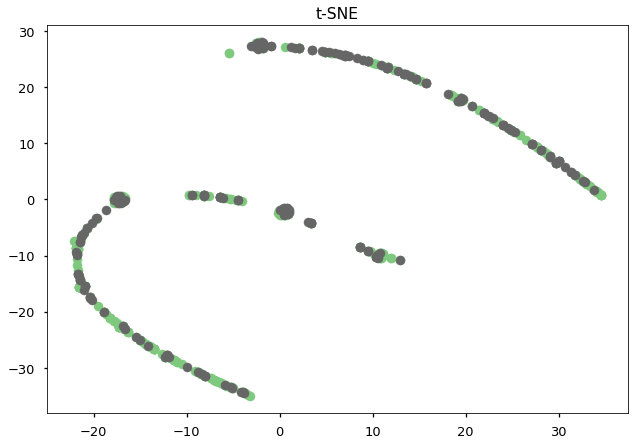

In [76]:
tsne2 = TSNE(n_components=2, random_state=0)
do_plot(tsne2.fit_transform(df_num), 't-SNE', labels)

# PCA Decomposition

In [77]:
pca = decomposition.PCA()

NameError: name 'decomposition' is not defined

In [ ]:
pca.fit(df_num)

In [ ]:
pca.components_.shape

In [ ]:
df_num.info()

In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca = decomposition.PCA(n_components=2)

In [ ]:
pca.fit(df_num)

In [ ]:
pca.components_.shape

In [ ]:
plt.figure(figsize=(20,4))
sns.heatmap(pd.DataFrame(pca.components_, index=['pc1', 'pc2'], columns=df_num.columns), annot=True, cmap='coolwarm', center=0)